<hr style="border:2px solid gray"> </hr>

# Homework 1 - Traveling Salesman Problem

## Example Code

### Algorithm 4: Genetic Algorithm

### Author: Wangduk Seo (CAU AI Lab)
<hr style="border:2px solid gray"> </hr>

# Step 0. Importing packages and Global Settings

In [1]:
# package list
import tkinter as tk
from tkinter import filedialog
import numpy as np
import sys
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import time

# Global Variables
# Genetic Algorithm
POOL_SIZE = 100
MUTATION_RATIO = 0.03
MUTATION_ITER = int(POOL_SIZE * MUTATION_RATIO)
RANDOM_RATIO = 0.1
ACCEPT_RATIO = 0.001
ITERATIONS = 20000
K = 10
np.random.seed(0)

# Plot Settings
PLOT_MODE = True # Draw Route
PLT_INTERVAL = 100 # Draw Route every 100 iterations
plt.ion()

# First City Index
FIRST_IDX = 0

# Step 1. Data Loading

In [2]:
def fileloader():
    # Data loading
    root = tk.Tk()
    root.withdraw()

    file_path = filedialog.askopenfilename()
    if file_path == '':
        raise Exception('Cannot load a data file')
    root.destroy()
    #     Data Format
    #     ---------------------------------------------------------
    #     NAME : pia3056
    #     COMMENT : Bonn VLSI data set with 3056 points
    #     COMMENT : Uni Bonn, Research Institute for Discrete Math
    #     COMMENT : Contributed by Andre Rohe
    #     TYPE : TSP
    #     DIMENSION : 3056 -----------------------------|
    #     EDGE_WEIGHT_TYPE : EUC_2D                     |
    #     NODE_COORD_SECTION                            |
    #     1 0 11 (2 dimentional coordinate of city)     |
    #     2 0 115                                       |
    #     ...                                           |
    #     ...(Total 3056 nodes)<------------------------|
    #     EOF
    #     ---------------------------------------------------------
    with open(file_path, "r") as file:
        file_str = file.readlines()

    # Get the coordinates of cities
    coord_str = file_str[8:-1]  # first city string to last city string (EOF 전까지)
    coord_list = np.zeros((len(coord_str), 2))
    for idx, item in enumerate(coord_str):
        coord_split = item.split()
        coord_list[idx, 0] = int(coord_split[1])
        coord_list[idx, 1] = int(coord_split[2])

    return coord_list

# Step 2. Initialization

In [3]:
def path_cost(path_map, path):
    # The array of cost between cities in the path
    cnt_cities = path_map.shape[0]
    cost_arr = np.zeros(cnt_cities)
    for i in range(cnt_cities):
        cost_arr[i] = path_map[path[i], path[i+1]]

    return cost_arr


def initialize_greedy(coord_list, first_idx):
    cnt_cities = len(coord_list)
    # Initialize path and insert first city index to the first and last elements
    path = np.zeros(cnt_cities + 1, dtype=np.int)
    path[0], path[-1] = first_idx, first_idx

    # Euclidean distance map between cities
    path_map = euclidean_distances(coord_list, coord_list)

    cities_tovisit = np.ones((cnt_cities), dtype=np.bool)
    cities_tovisit[first_idx] = False

    # Iteratively Connect nearest cities
    for i in range(1, cnt_cities):
        start_idx = path[i - 1]
        distance_from_start = path_map[start_idx, :]
        nearest_list = np.argsort(distance_from_start)
        for idx in range(len(nearest_list)):
            # check the nearest city is visited
            if cities_tovisit[nearest_list[idx]]:
                nearest_city = nearest_list[idx]
                break
        cities_tovisit[nearest_city] = False
        path[i] = nearest_city

    return path_map, path


def initialize_random(coord_list, first_idx):
    cnt_cities = len(coord_list)
    path = np.zeros(cnt_cities + 1, dtype=np.int)

    path[0], path[-1] = first_idx, first_idx
    # Euclidean distance map between cities
    path_map = euclidean_distances(coord_list, coord_list)

    # city indices without first city index
    cities_tovisit = np.delete(np.arange(cnt_cities), first_idx)
    cities_random = np.random.permutation(cities_tovisit)
    path[1:-1] = cities_random

    return path_map, path


def two_opt_swap(path_map, path, steps):
    cnt_cities = path_map.shape[0]
    curr_path = path.copy()
    for i in range(steps):
        # Select two indices for flip points
        sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities + 1), 2))
        if sel_idx[1] - sel_idx[0] <= 1:
            continue
        # Path Flip and update cost array
        curr_path[sel_idx[0]:sel_idx[1]] = np.flip(curr_path[sel_idx[0]: sel_idx[1]])

    cost_arr = path_cost(path_map, curr_path)
    curr_cost = cost_arr.sum()

    return curr_path, curr_cost


def initialization(coord_list):
    # Greedy Search + two_opt + random
    cnt_cities = len(coord_list)
    path_pool = np.zeros((POOL_SIZE, cnt_cities + 1), dtype=np.int)
    pool_cost = np.zeros(POOL_SIZE)
    num_random = int(POOL_SIZE * RANDOM_RATIO)

    path_map, path_pool[0, :] = initialize_greedy(coord_list, FIRST_IDX)
    pool_cost[0] = path_cost(path_map, path_pool[0, :]).sum()
    for i in range(1, num_random + 1):
        _, path_pool[i, :] = initialize_random(coord_list, FIRST_IDX)
        pool_cost[i] = path_cost(path_map, path_pool[i, :]).sum()

    for i in range(num_random + 1, POOL_SIZE):
        path_pool[i, :], pool_cost[i] = two_opt_swap(path_map, path_pool[0, :], np.random.randint(10, 25))

    return path_map, path_pool, pool_cost

# Step 3. Selection
## Tournament Selection

In [4]:
def selection(pool_cost, k):
    # tournament selection
    selected_indices = np.random.permutation(POOL_SIZE)
    selected_indices = selected_indices[:k]

    selected_cost = pool_cost[selected_indices]
    sorted_indices = np.argsort(selected_cost)

    indices = selected_indices[sorted_indices[:2]]

    return indices

# Step 4. Crossover
## PMX Crossover

In [5]:
def crossover(path1, path2):
    # pmx crossover
    path_size = len(path1) - 1
    plist1 = np.zeros(path_size, dtype=np.int)
    plist2 = np.zeros(path_size, dtype=np.int)

    child1 = path1.copy()
    child2 = path2.copy()

    for i in range(path_size):
        plist1[child1[i]] = i
        plist2[child2[i]] = i

    sel_idx = np.random.randint(1, path_size, size=2)
    if sel_idx[0] > sel_idx[1]:
        sel_idx[0], sel_idx[1] = sel_idx[1], sel_idx[0]

    for i in range(sel_idx[0], sel_idx[1]):
        # Swap Points
        temp1, temp2 = child1[i], child2[i]
        child1[i], child1[plist1[temp2]] = temp2, temp1
        child2[i], child2[plist2[temp1]] = temp1, temp2
        plist1[temp1], plist1[temp2] = plist1[temp2], plist1[temp1]
        plist2[temp1], plist2[temp2] = plist2[temp2], plist2[temp1]

    return child1, child2

# Step 5. Mutation
## Swap Mutation

In [6]:
def mutation(path, path_map):
    # Swap mutation
    path_size = len(path) - 1
    sel_idx = np.random.randint(1, path_size, size=2)
    child = path.copy()
    child[sel_idx[0]], child[sel_idx[1]] = child[sel_idx[1]], child[sel_idx[0]]
    cost1 = path_cost(path_map, path).sum()
    cost2 = path_cost(path_map, child).sum()
    rate = np.random.rand(1)
    
    if cost1 < cost2 :
        if ACCEPT_RATIO > rate :
            return child
        else :
            return path
    else : 
        if ACCEPT_RATIO > rate:
            return path
        else :
            return child

# Step 6. Searching a path

## Algorithm 4. GA

In [7]:
def ga_search(coord_list):
    # Initialization
    path_map, path_pool, pool_cost = initialization(coord_list)

    for i in range(ITERATIONS):
        sort_cost = np.argsort(pool_cost)
        path_pool = path_pool[sort_cost, :]
        pool_cost = pool_cost[sort_cost]

        # Selection
        indices = selection(pool_cost, K)
        # Crossover
        child1, child2 = crossover(path_pool[indices[0], :], path_pool[indices[1], :])
        
        path_pool[-1, :], pool_cost[-1] = child1, path_cost(path_map, child1).sum()
        path_pool[-2, :], pool_cost[-2] = child2, path_cost(path_map, child2).sum()
        
        # Mutation
            #sort_cost = np.argsort(pool_cost)
            #path_pool = path_pool[sort_cost, :]
            #pool_cost = pool_cost[sort_cost]
        for j in range(MUTATION_ITER):
            index = j+3
            child3 = mutation(path_pool[indices[0], :],path_map)
            path_pool[-index, :], pool_cost[-index] = child3, path_cost(path_map, child3).sum()

    sort_cost = np.argsort(pool_cost)
    path_pool = path_pool[sort_cost, :]
    pool_cost = pool_cost[sort_cost]

    return path_pool[0], pool_cost[0]

# Main

Execution Time: 407.54419231414795
Path: [0, 22, 21, 54, 23, 1, 55, 63, 62, 60, 59, 67, 68, 78, 91, 90, 89, 118, 119, 121, 131, 137, 136, 130, 127, 148, 149, 144, 151, 152, 147, 146, 145, 138, 132, 128, 126, 170, 173, 204, 206, 207, 208, 175, 227, 226, 236, 237, 254, 250, 253, 252, 251, 263, 235, 225, 224, 203, 202, 201, 200, 199, 205, 198, 197, 196, 195, 194, 193, 192, 191, 190, 216, 217, 218, 234, 248, 247, 233, 246, 245, 232, 215, 189, 188, 187, 186, 185, 184, 183, 182, 213, 214, 223, 242, 243, 231, 264, 257, 258, 259, 260, 265, 266, 261, 268, 262, 267, 269, 297, 298, 270, 271, 272, 302, 303, 304, 300, 299, 309, 310, 311, 312, 316, 325, 334, 337, 336, 333, 324, 315, 323, 314, 313, 356, 386, 387, 388, 357, 389, 408, 419, 420, 436, 450, 446, 445, 444, 443, 442, 441, 440, 439, 438, 437, 428, 412, 413, 429, 435, 430, 414, 415, 431, 432, 416, 417, 433, 434, 418, 401, 402, 385, 384, 400, 399, 398, 397, 381, 382, 383, 380, 396, 395, 393, 378, 379, 342, 349, 355, 377, 376, 375, 374, 373, 37

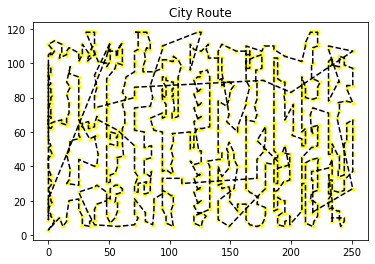

In [8]:
try:
    coord_list = fileloader()
except Exception as e:
    print('예외 발생', e)
    sys.exit()

start_time = time.time()

best_path, best_cost = ga_search(coord_list)

if PLOT_MODE:
    figure, ax = plt.subplots()
    plt.scatter(coord_list[:, 0], coord_list[:, 1], c='yellow', s=10)
    plt.title('City Route')
    coord_path = coord_list
    coord_path = np.append(coord_path, coord_path[best_path[0], :].reshape(1, 2), axis=0)
    coord_path[:, :] = coord_path[best_path, :]
    lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--')
    figure.canvas.draw()

print('Execution Time: ' + str(time.time() - start_time))
print('Path: ' + str(best_path.tolist()))
print('Cost: ' + str(best_cost))